Mounted at /content/gdrive
  filename   target  distance_to_beachside  \
0       C1  Coastal                    1.5   
1       C2  Coastal                    1.5   
2       C3  Coastal                    5.0   
3       C4  Coastal                    5.0   
4       C5  Coastal                    1.5   

   drive_hours_in_coastal_area_perday  car_age  
0                                   6        4  
1                                   6        4  
2                                   4        5  
3                                   4        5  
4                                   3        7  
Found 1155 images belonging to 2 classes.
Found 145 images belonging to 2 classes.
Found 144 images belonging to 2 classes.


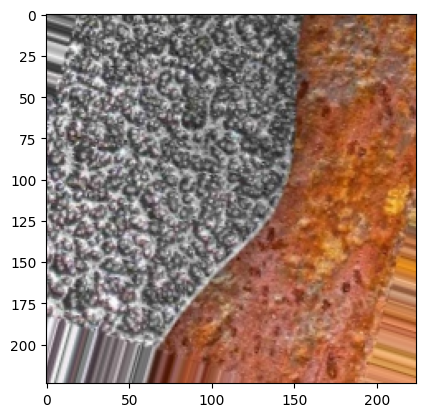

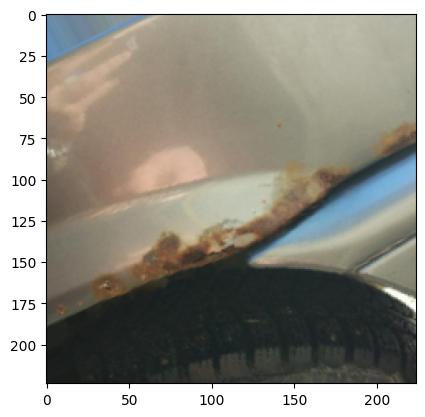

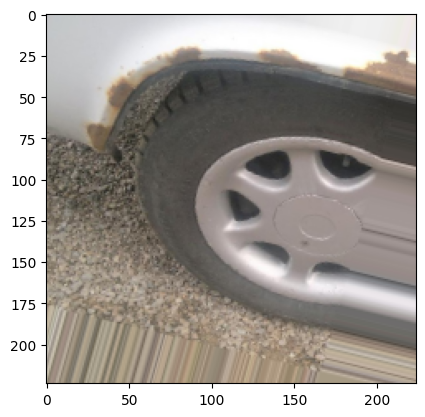

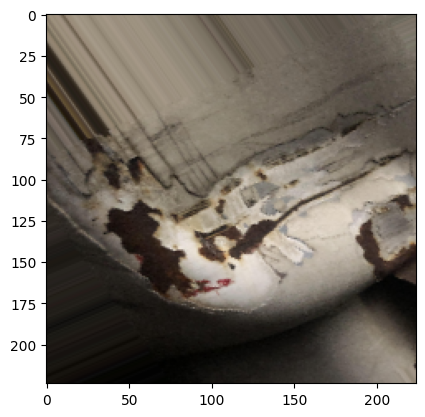

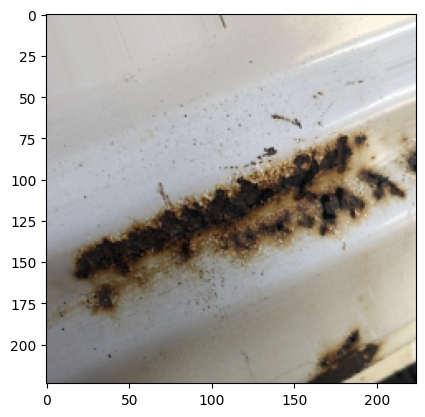

Epoch 1/50
36/36 [==============================] - ETA: 0s - loss: 1.0811 - accuracy: 0.5868 - precision: 0.6068 - recall: 0.8795 - f1_score: 0.6816

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 415s 11s/step - loss: 1.0811 - accuracy: 0.5868 - precision: 0.6068 - recall: 0.8795 - f1_score: 0.6816 - val_loss: 0.6918 - val_accuracy: 0.5703 - val_precision: 0.5748 - val_recall: 0.9865 - val_f1_score: 0.7248
Epoch 2/50
36/36 [==============================] - 59s 2s/step - loss: 0.6866 - accuracy: 0.5984 - precision: 0.5970 - recall: 1.0000 - f1_score: 0.7496 - val_loss: 0.6833 - val_accuracy: 0.6094 - val_precision: 0.6142 - val_recall: 0.9873 - val_f1_score: 0.7567
Epoch 3/50
36/36 [==============================] - 65s 2s/step - loss: 0.6595 - accuracy: 0.6020 - precision: 0.6011 - recall: 0.9985 - f1_score: 0.7399 - val_loss: 0.6571 - val_accuracy: 0.6016 - val_precision: 0.6016 - val_recall: 1.0000 - val_f1_score: 0.7488
Epoch 4/50
36/36 [==============================] - 69s 2s/step - loss: 0.6490 - accuracy: 0.6046 - precision: 0.6040 - recall: 0.9941 - f1_score: 0.7497 - val_loss: 0.5921 - val_accuracy: 0.6094 - val_precision: 0.60

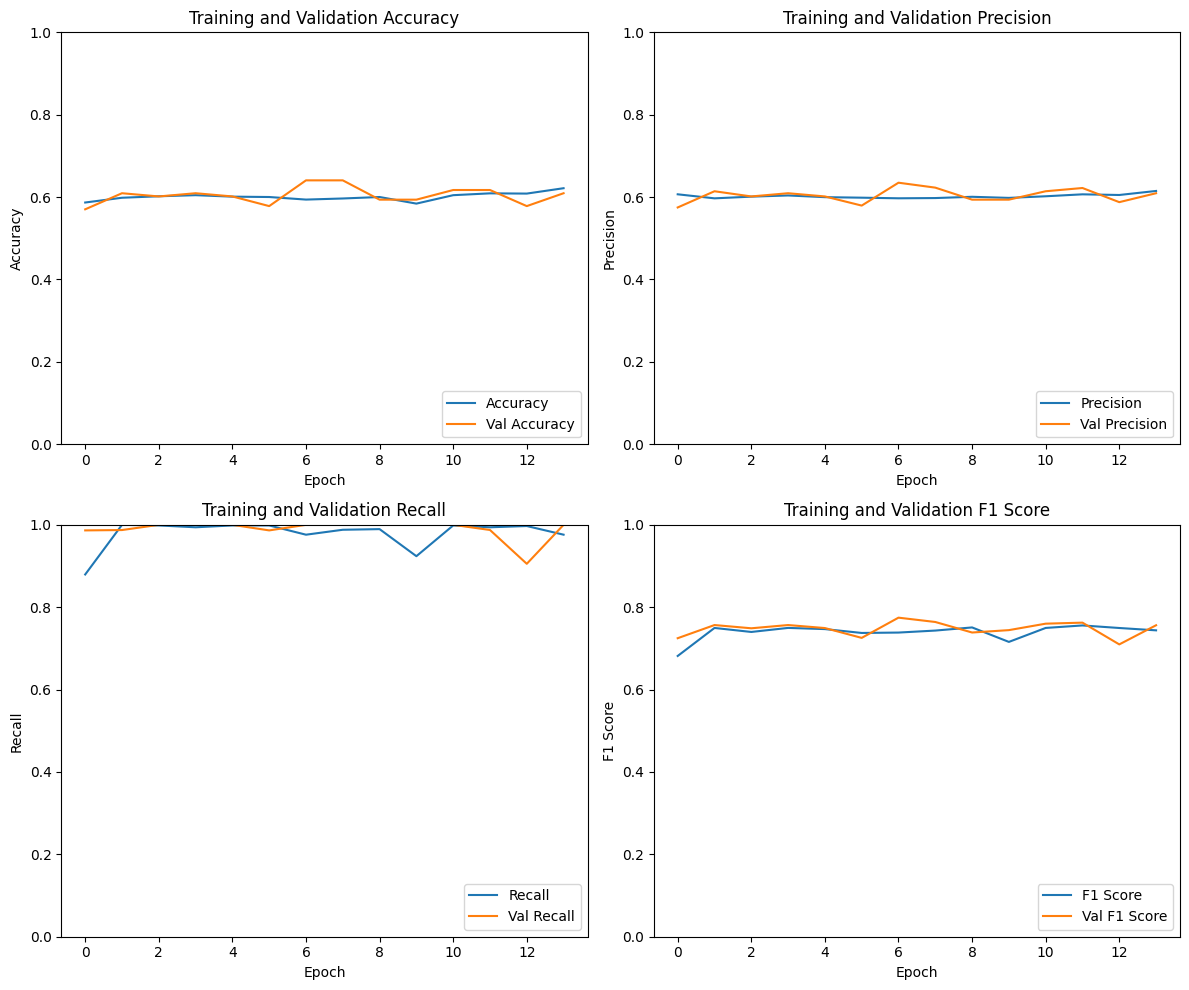

In [1]:
# Import necessary libraries
from google.colab import drive
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects, custom_object_scope
import json

# Mount Google Drive
drive.mount('/content/gdrive')

# Load the Excel file
excel_path = '/content/gdrive/My Drive/My_Research/Car_Corrosion/Data_Sets/paraFinal.xlsx'
data = pd.read_excel(excel_path)
print(data.head())

# Define directories for the image data
TRAIN_DIR = '/content/gdrive/My Drive/Car_Corrosion_Dataset/train'
TEST_DIR = '/content/gdrive/My Drive/Car_Corrosion_Dataset/test'
VAL_DIR = '/content/gdrive/My Drive/Car_Corrosion_Dataset/val'

# Create ImageDataGenerator instances for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess the training data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Load and preprocess the validation data
validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Load and preprocess the test data
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Display a few images to verify the data loading process
x_batch, y_batch = next(train_generator)
for i in range(0, 5):
    image = x_batch[i]
    plt.imshow(image)
    plt.show()

# Define a custom F1-score metric
def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Define and compile the optimized model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', f1_score])

# Define callbacks for early stopping and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    filepath='/content/gdrive/My Drive/My_Research/Car_Corrosion/result_YOLO4/best_model.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

# Train the model with callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate the model
loss, accuracy, precision, recall, f1 = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy*100:.2f}%')
print(f'Test Precision: {precision*100:.2f}%')
print(f'Test Recall: {recall*100:.2f}%')
print(f'Test F1 Score: {f1*100:.2f}%')

# Define the paths where the model, weights, and history will be saved
model_save_path = '/content/gdrive/My Drive/My_Research/Car_Corrosion/result_YOLO4/my_model.h5'
weights_save_path = '/content/gdrive/My Drive/My_Research/Car_Corrosion/result_YOLO4/my_model_weights.h5'
history_save_path = '/content/gdrive/My Drive/My_Research/Car_Corrosion/result_YOLO4/my_model_history.json'

# Save the entire model
model.save(model_save_path)
print(f'Model saved to {model_save_path}')

# Save model weights only
model.save_weights(weights_save_path)
print(f'Model weights saved to {weights_save_path}')

# Save the training history
history_dict = history.history
with open(history_save_path, 'w') as f:
    json.dump(history_dict, f)
print(f'Training history saved to {history_save_path}')

# Load the entire model using custom_object_scope to ensure custom metrics are recognized
with custom_object_scope({'f1_score': f1_score}):
    saved_model = load_model(model_save_path)
    print('Model loaded successfully.')

# Load the training history
with open(history_save_path, 'r') as f:
    loaded_history_dict = json.load(f)

# Plot training history
plt.figure(figsize=(12, 10))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(loaded_history_dict['accuracy'], label='Accuracy')
plt.plot(loaded_history_dict['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Precision
plt.subplot(2, 2, 2)
plt.plot(loaded_history_dict['precision'], label='Precision')
plt.plot(loaded_history_dict['val_precision'], label='Val Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Precision')

# Recall
plt.subplot(2, 2, 3)
plt.plot(loaded_history_dict['recall'], label='Recall')
plt.plot(loaded_history_dict['val_recall'], label='Val Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')

# F1 Score
plt.subplot(2, 2, 4)
plt.plot(loaded_history_dict['f1_score'], label='F1 Score')
plt.plot(loaded_history_dict['val_f1_score'], label='Val F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation F1 Score')

plt.tight_layout()
plt.show()


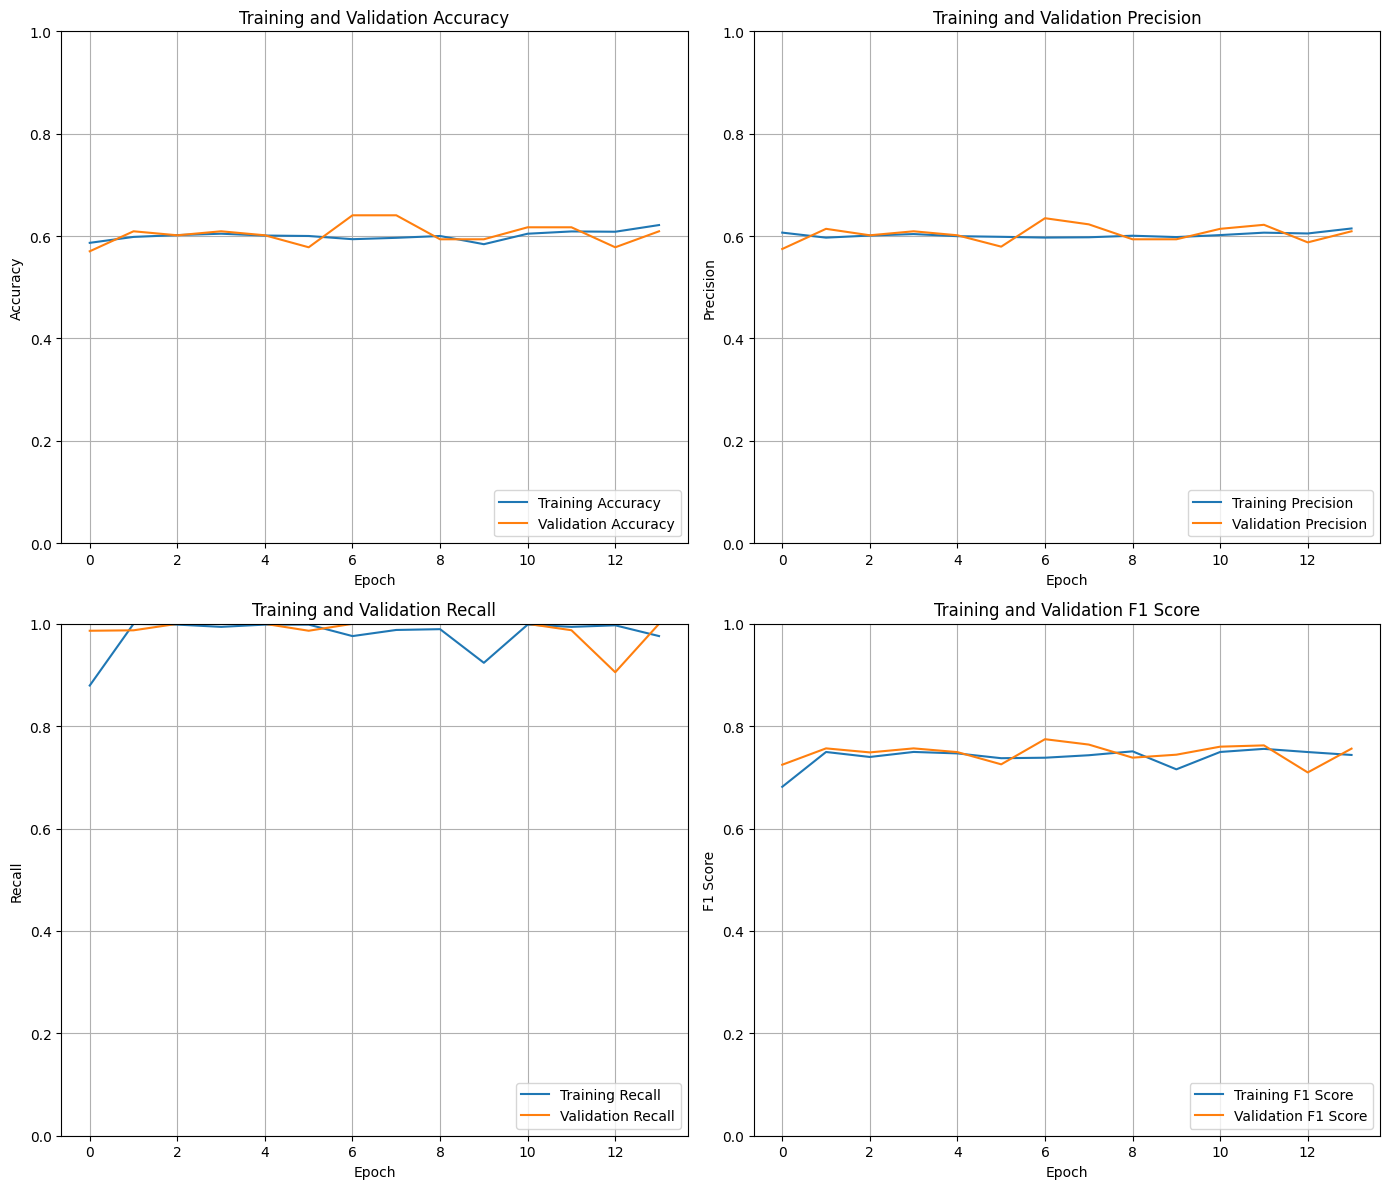

In [2]:
# Plot training history with improved visualization
plt.figure(figsize=(14, 12))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(loaded_history_dict['accuracy'], label='Training Accuracy')
plt.plot(loaded_history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True)

# Precision
plt.subplot(2, 2, 2)
plt.plot(loaded_history_dict['precision'], label='Training Precision')
plt.plot(loaded_history_dict['val_precision'], label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Precision')
plt.grid(True)

# Recall
plt.subplot(2, 2, 3)
plt.plot(loaded_history_dict['recall'], label='Training Recall')
plt.plot(loaded_history_dict['val_recall'], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')
plt.grid(True)

# F1 Score
plt.subplot(2, 2, 4)
plt.plot(loaded_history_dict['f1_score'], label='Training F1 Score')
plt.plot(loaded_history_dict['val_f1_score'], label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation F1 Score')
plt.grid(True)

plt.tight_layout()
plt.show()
